## Loading

In [1]:
%load_ext autoreload
%autoreload 2

import model as m
import data_processing as dp
import feature_engineering as fe
import make_plots as mp
import parameters as p
import evaluation as e
import os
import matplotlib.pyplot as plt
import optuna
import seaborn as sns

import pandas as pd
import numpy as np

default_max_rows = pd.get_option('display.max_rows')

In [2]:
# assert len(p.missing_files) == 0
# merged_data_daily, merged_data_monthly = dp.data_loading(p.daily_files, p.monthly_files)
# merged_data_daily, merged_data_monthly = dp.get_market_data(merged_data_daily, merged_data_monthly)
# merged_data_daily = fe.calculate_stock_level_alpha_and_beta(merged_data_daily)
# merged_data_monthly = dp.merge_economic_data(merged_data_monthly)
# dp.save_preprocessed_data(merged_data_monthly, "merged_data_monthly" , index=False); dp.save_preprocessed_data(merged_data_daily, "merged_data_daily", index=False)

# merged_data_daily, merged_data_monthly = dp.data_loading(p.daily_files, p.monthly_files)
# data_daily, data_monthly = fe.feature_construction(merged_data_daily.copy(), merged_data_monthly.copy())
# data_monthly_merged = dp.merge_daily_and_monthly_data(data_daily, data_monthly)

# dp.save_preprocessed_data(data_monthly_merged, "data_monthly_merged")
data_monthly_merged = pd.read_csv(os.path.join(p.cleanedDataPath, "data_monthly_merged.csv"), index_col='date', dtype={p.stockID: str}, parse_dates=True)

data_monthly_imputed = dp.handle_crosssectional_na(data_monthly_merged.copy())
data_monthly_transformed = fe.transform_features(data_monthly_imputed)

Dropped 0 rows with more than 78.38352128462151% missing values.


Increase in missing statistics for each column:
beta_000905: 6.91%
daily_ret_vol_roll_126: 0.03%
return_daily: 0.00%
total_market_value: 5.53%
turnover_daily: 5.53%
000905_close: 0.00%
000905_return_daily: 0.00%
alpha: 6.57%
beta: 6.57%
betasq: 6.57%
maxret: 0.00%
MACD: 0.00%
MACD_Signal: 0.00%
SMA: 0.00%
Upper_Band: 0.03%
Lower_Band: 0.03%
RSI: 3.02%
ROC: 0.31%
volatility_252: 6.72%
volatility_120: 3.29%
volatility_60: 1.65%
SMA_5: 0.00%
SMA_10: 0.00%
SMA_20: 0.00%
SMA_50: 0.00%
SMA_100: 0.00%
SMA_200: 0.00%
illiquidity_monthly: 0.57%
mve_log: 6.22%
return_monthly: 0.54%
ret_vol_monthly: 0.54%
std_dolvol_monthly: 0.57%
std_turnover_monthly: 5.95%
zero_trade_days: 0.81%
000905_return_monthly: 0.54%
CPI: 0.53%
CPI_pct_change: 0.53%
chmom: 10.54%
mom1m_return_monthly: 1.10%
mom6m_return_monthly: 3.85%
mom12m_return_monthly: 6.95%
mom24m_return_monthly: 6.95%
mom36m_return_monthly: 6.95%
mom1m_000905_return_monthly: 1.10%


In [3]:
# grouped = data_monthly_merged.groupby('Ticker')
# for ticker, group in grouped:
#     # Sort the group by 'date'
#     group = group.sort_values(by='date')
#     # Use `shift` to compare with the previous row
#     group['prev_zero_trade_days'] = group['zero_trade_days'].shift(1)
#     # Find rows where the previous 'zero_trade_days' is not NaN, but the current is NaN
#     mask = group['prev_zero_trade_days'].notna() & group['zero_trade_days'].isna()
#     if mask.any():
#         print(f"For ticker {ticker}: There is at least one case where the previous 'zero_trade_days' is not NaN, but the current is NaN.")

## Baseline Model

In [4]:
data_monthly_nona = data_monthly_imputed.dropna().copy()
removed_percentage = (1 - len(data_monthly_nona) / len(data_monthly_imputed)) * 100
print(f"Removed {len(data_monthly_nona)} rows, which is {removed_percentage:.2f}%.")

Removed 478422 rows, which is 8.04%.


In [4]:
price_return_related = ['close', 'close_adj', 'return_daily', '000905_close', 
                        '000905_return_daily', '000905_return_monthly', 'return_monthly',
                        'alpha', 'beta'
                        ]              

data_baseline = data_monthly_nona.drop(price_return_related,axis=1)

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = m.split_train_val_test(data_baseline.copy(), colsToDrop = ['excess_return'])
input_dim=X_train.shape[1]

print("Training set range:")
print(X_train.index.min(), "to", X_train.index.max())

print("Validation set range:")
print(X_val.index.min(), "to", X_val.index.max())

print("Testing set range:")
print(X_test.index.min(), "to", X_test.index.max())

Training set range:
2013-02-28 00:00:00 to 2017-12-31 00:00:00
Validation set range:
2018-01-31 00:00:00 to 2019-12-31 00:00:00
Testing set range:
2020-01-31 00:00:00 to 2021-12-31 00:00:00


### Hyperparameter tuning

In [6]:
# models_to_tune = [
#     m.OLSModel,
#     m.OLS3Model,
#     m.PLSModel,
#     m.LASSOModel,
#     m.ElasticNetModel,
#     m.GBRTModel,
#     m.RFModel,
#     m.XGBoostModel
# ]
# models_to_tune = [
#     m.XGBoostModel
# ]
# best_trials = e.hyperparameter_tuning(X_train, y_train, X_val, y_val, models_to_tune, n_trials=100)

In [7]:
# e.nn_tunning(range(1, 5+1), X_train_scaled, y_train, X_val_scaled, y_val)

### Testing

In [8]:
model_classes = [
    m.OLSModel(),
    m.OLS3Model(),
    m.PLSModel(),
    m.LASSOModel(),
    m.ElasticNetModel(),
    m.GBRTModel(), #extremely slow 
    m.RFModel(), 
    m.XGBoostModel()
]
num_layers_range = range(1, 5+1)
for num_layers in num_layers_range:
    model_classes.append(m.NNModel(input_dim=input_dim, num_layers=num_layers))
models_fitted, model_res, model_r_2 = m.fit_model(X_train, X_test,  X_val, y_val, y_train, y_test, model_classes)

OLSModel
OLS3Model
PLSModel
LASSOModel
ElasticNetModel
GBRTModel
RFModel
XGBoostModel
NNModel_nn1


Training:  10%|█         | 10/100 [01:23<12:28,  8.32s/it, Training loss=0.0218, Validation loss=0.02] 


Early stopping triggered at epoch 11
NNModel_nn2


Training:   7%|▋         | 7/100 [01:05<14:24,  9.29s/it, Training loss=0.0218, Validation loss=0.0203]


Early stopping triggered at epoch 8
NNModel_nn3


Training:   8%|▊         | 8/100 [01:21<15:32, 10.14s/it, Training loss=0.0218, Validation loss=0.0201]


Early stopping triggered at epoch 9
NNModel_nn4


Training:  10%|█         | 10/100 [01:58<17:45, 11.84s/it, Training loss=0.0218, Validation loss=0.02] 


Early stopping triggered at epoch 11
NNModel_nn5


Training:   5%|▌         | 5/100 [01:06<20:56, 13.23s/it, Training loss=0.0218, Validation loss=0.0201]

Early stopping triggered at epoch 6
OLSModel: -3.952722727443433
OLS3Model: -3.944255798884204
PLSModel: -3.9588289846051
LASSOModel: -3.957814939871847
ElasticNetModel: -3.957851629009099
GBRTModel: -3.978476442409592
RFModel: -4.262471221044477
XGBoostModel: -3.963006762336992
NNModel_nn1: -4.020113327689079
NNModel_nn2: -3.946702108982601
NNModel_nn3: -3.9590972154298
NNModel_nn4: -3.9614414022136
NNModel_nn5: -3.9706976659848072


### Feature Importance

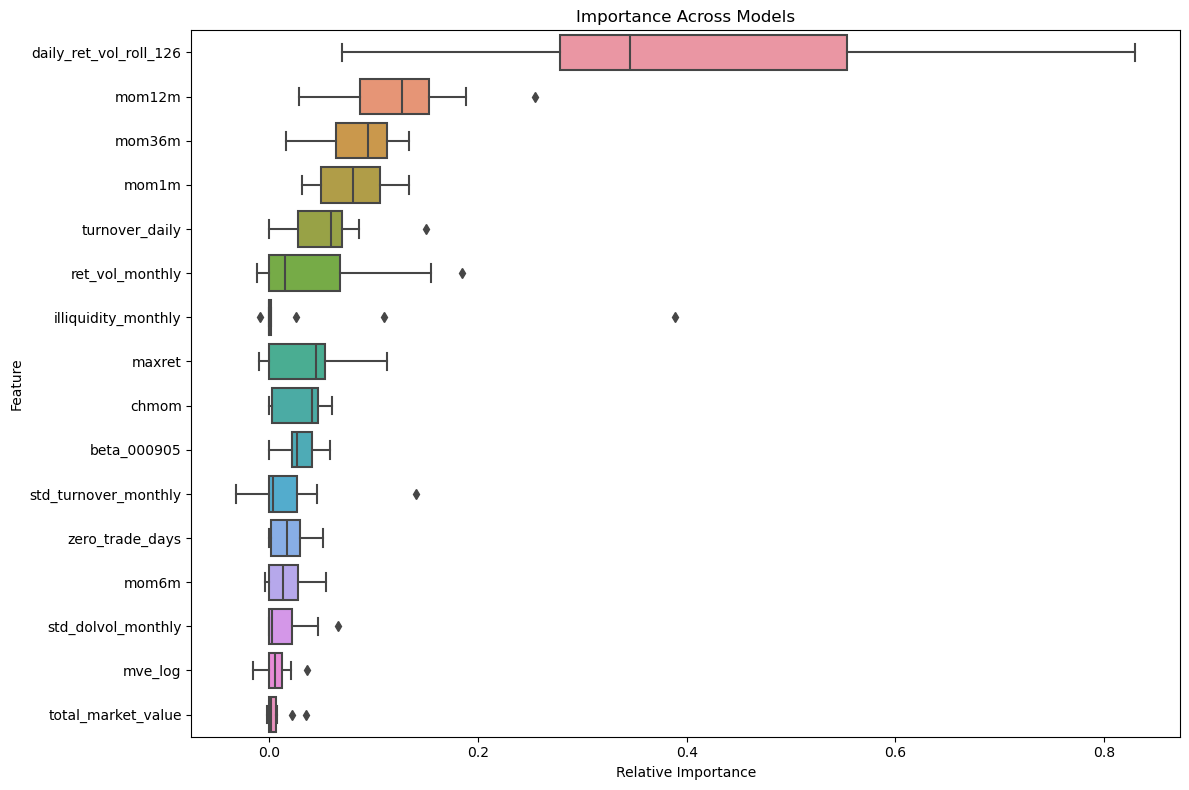

In [37]:
X_train, y_train, X_val, y_val, X_test, y_test = m.split_train_val_test(data_baseline.copy(), colsToDrop = ['excess_return'])
importance_df_baseline = e.calculate_feature_importance(model_classes, X_train, y_train, X_val, y_val, features=X_train.columns, permutation_importance=True)
mp.feature_importance_boxplot(importance_df_baseline)
# sorted_df = mp.characteristic_feature_importance(importance_df_baseline)

## Current Model

In [3]:
data_monthly_nona = data_monthly_transformed.dropna().copy()
removed_percentage = (1 - len(data_monthly_nona) / len(data_monthly_transformed)) * 100
print(f"Removed {len(data_monthly_nona)} rows, which is {removed_percentage:.2f}%.")

cols_to_drop = ['close', 'return_daily', '000905_return_daily', 'return_monthly',
                'alpha', 'beta_000905'
                ]             
data_model = data_monthly_nona.copy()

X_train, y_train, X_val, y_val, X_test, y_test = m.split_train_val_test(data_model.copy(), colsToDrop = cols_to_drop)
input_dim=X_train.shape[1]


print("Training set range:")
print(X_train.index.min(), "to", X_train.index.max())

print("Validation set range:")
print(X_val.index.min(), "to", X_val.index.max())

print("Testing set range:")
print(X_test.index.min(), "to", X_test.index.max())

Removed 478422 rows, which is 8.04%.
Training set range:
2013-02-28 00:00:00 to 2017-12-31 00:00:00
Validation set range:
2018-01-31 00:00:00 to 2019-12-31 00:00:00
Testing set range:
2020-01-31 00:00:00 to 2021-12-31 00:00:00


## Tuning

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor 
import xgboost as xgb


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

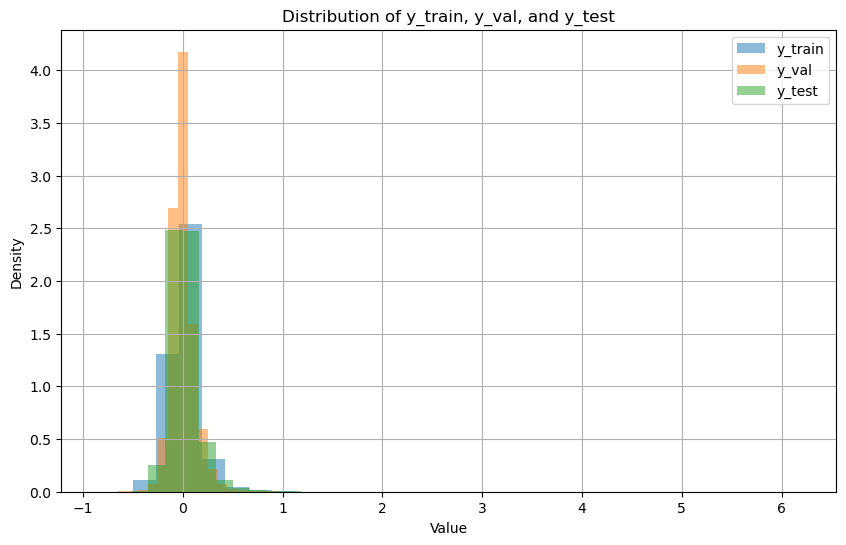

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=30, alpha=0.5, label='y_train', density=True)
plt.hist(y_val, bins=30, alpha=0.5, label='y_val', density=True)
plt.hist(y_test, bins=30, alpha=0.5, label='y_test', density=True)

plt.title('Distribution of y_train, y_val, and y_test')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

##### LinearRegression

In [6]:
model = LinearRegression(n_jobs=-1).fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
r_2_train = e.calculate_r2_oos(y_train, model.predict(X_train_scaled))
r_2_val = e.calculate_r2_oos(y_val, predictions)
print(f"r_2_train: {r_2_train}, r_2_val: {r_2_val}", )

r_2_train: 0.1358408773933597, r_2_val: -0.9043189165196943


##### Huberloss

In [12]:
model = HuberRegressor(max_iter=5000).fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
r_2_train = e.calculate_r2_oos(y_train, model.predict(X_train_scaled))
r_2_val = e.calculate_r2_oos(y_val, predictions)
print(f"r_2_train: {r_2_train}, r_2_val: {r_2_val}", )

r_2_train: 0.11723599205212498, r_2_val: -0.19511840135249314


In [79]:
param_grid_huber = {
    'epsilon': [1, 1.35, 1.7, 3, 6, 10],
    'alpha': [0, 0.01, 0.1, 0.5, 1],
    'max_iter': [5000]
    }

results_huber = e.explore_parameter_grid(HuberRegressor, param_grid_huber, X_train_scaled, y_train, X_val_scaled, y_val)

Exploring Parameters: 100%|██████████| 30/30 [03:30<00:00,  7.01s/it]


c:\Users\Howard\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


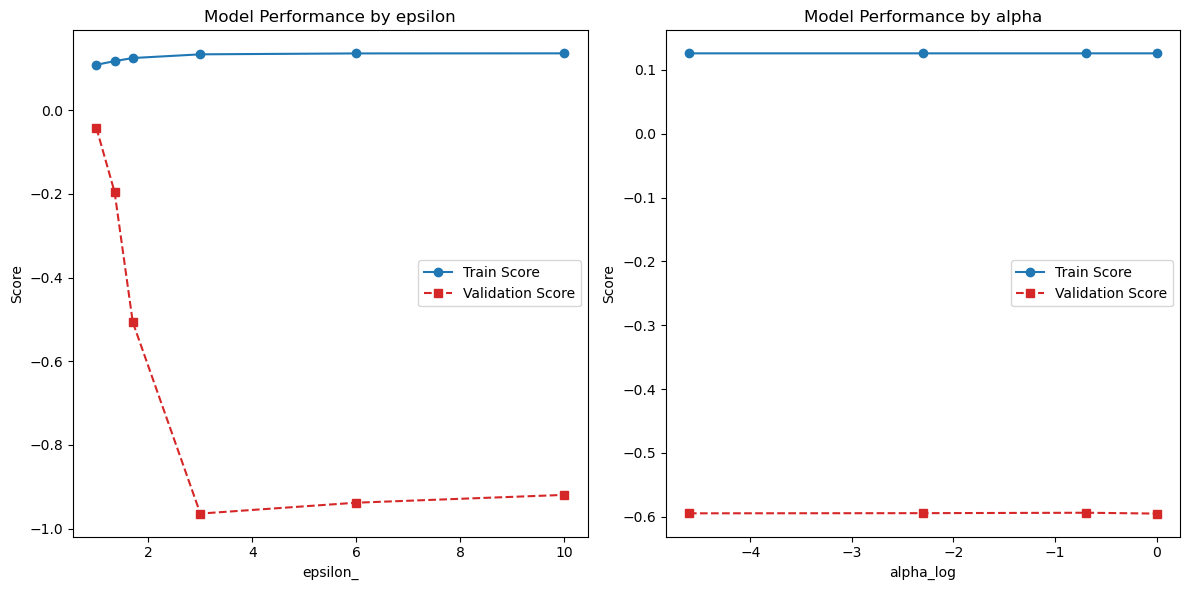

In [82]:
mp.plot_model_performance(results_huber.copy(), param_grid_huber)

##### PLS

In [13]:
model = PLSRegression(max_iter=5000).fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
r_2_train = e.calculate_r2_oos(y_train, model.predict(X_train_scaled))
r_2_val = e.calculate_r2_oos(y_val, predictions)
print(f"r_2_train: {r_2_train}, r_2_val: {r_2_val}", )

r_2_train: 0.08403052996081861, r_2_val: 0.002011950337456714


In [71]:
n_feature = X_train_scaled.shape[1]
n_components = []
while n_feature != 1:
    n_components.append(n_feature)
    n_feature //= 1.5 
    n_feature = int(n_feature)

param_grid_pls = {
    'n_components': n_components,
    'max_iter': [5000]
    }

results_pls = e.explore_parameter_grid(PLSRegression, param_grid_pls.copy(), X_train_scaled, y_train, X_val_scaled, y_val)

Exploring Parameters:   0%|          | 0/8 [00:02<?, ?it/s]


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

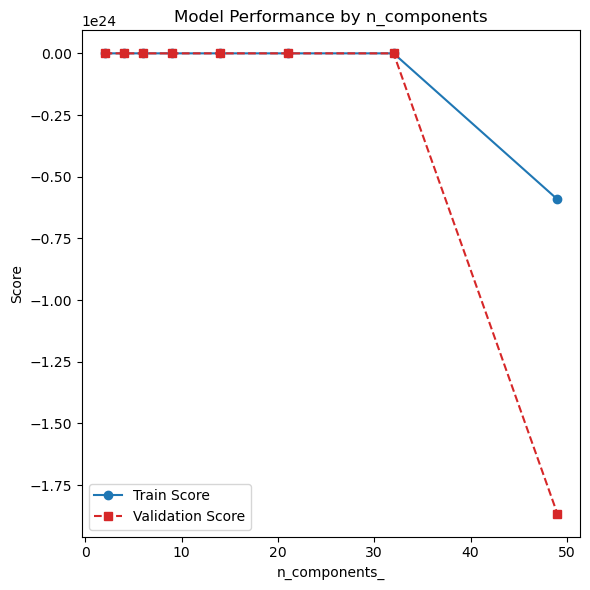

In [86]:
mp.plot_model_performance(results_pls.copy(), param_grid_pls)

##### Lasso

In [14]:
model = Lasso(max_iter=5000).fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
r_2_train = e.calculate_r2_oos(y_train, model.predict(X_train_scaled))
r_2_val = e.calculate_r2_oos(y_val, predictions)
print(f"r_2_train: {r_2_train}, r_2_val: {r_2_val}", )

r_2_train: 0.012424340633876652, r_2_val: -0.02392923386479051


In [17]:
param_grid_lasso = {
    'alpha': [0.0001, 0.001, 0.1, 1, 5, 10],
    'max_iter': [5000]
    }

results_lasso = e.explore_parameter_grid(Lasso, param_grid_lasso, X_train_scaled, y_train, X_val_scaled, y_val)

Exploring Parameters: 100%|██████████| 6/6 [00:22<00:00,  3.83s/it]


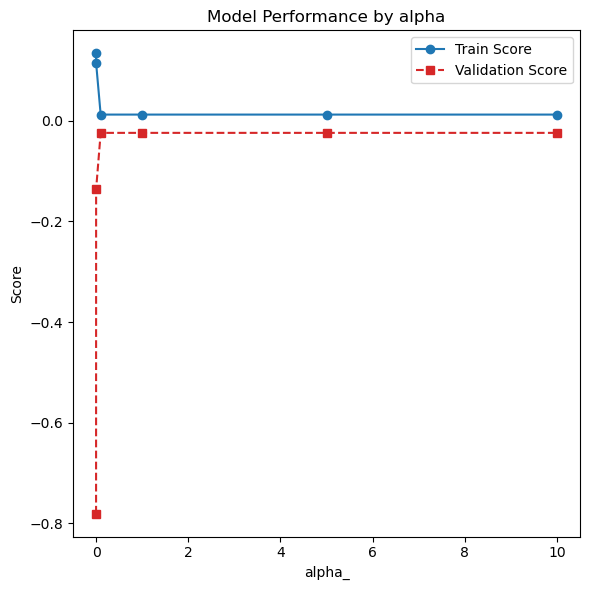

In [18]:
mp.plot_model_performance(results_lasso.copy(), param_grid_lasso)

#### ElasticNet

In [15]:
model = ElasticNet(max_iter=5000).fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
r_2_train = e.calculate_r2_oos(y_train, model.predict(X_train_scaled))
r_2_val = e.calculate_r2_oos(y_val, predictions)
print(f"r_2_train: {r_2_train}, r_2_val: {r_2_val}", )

r_2_train: 0.012424340633876652, r_2_val: -0.02392923386479051


In [28]:
param_grid_en = {
    'alpha': [0.001, 0.1, 1, 2, 4, 8, 16],
    'l1_ratio': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.7, 1],
    'max_iter': [5000]
    }

results_en = e.explore_parameter_grid(ElasticNet, param_grid_en, X_train_scaled, y_train, X_val_scaled, y_val)

Exploring Parameters: 100%|██████████| 56/56 [03:23<00:00,  3.63s/it]


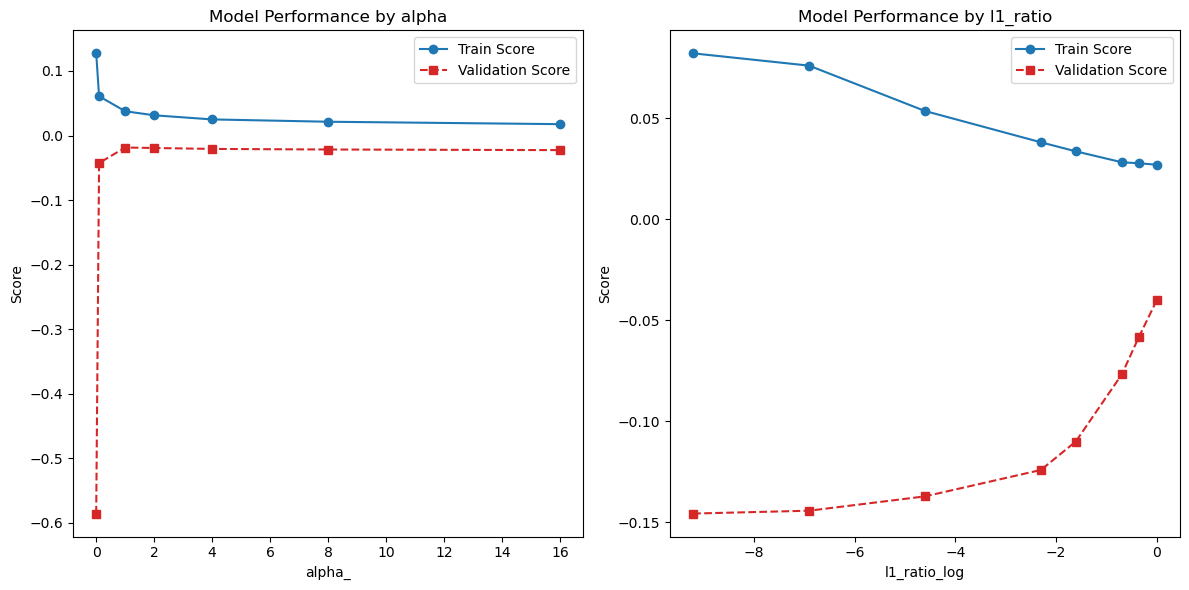

In [30]:
mp.plot_model_performance(results_en.copy(), param_grid_en)

### Random Forest

In [6]:
model = RandomForestRegressor(n_jobs=-1,n_estimators=50,random_state=p.RandomState).fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
r_2_train = e.calculate_r2_oos(y_train, model.predict(X_train_scaled))
r_2_val = e.calculate_r2_oos(y_val, predictions)
print(f"r_2_train: {r_2_train}, r_2_val: {r_2_val}", )

NameError: name 'RandomForestRegressor' is not defined

In [17]:
param_grid_rf = {
    'n_estimators': [50],  
    'criterion': ['friedman_mse', 'squared_error','friedman_mse', 'squared_error','friedman_mse', 'squared_error','friedman_mse', 'squared_error','friedman_mse', 'squared_error','friedman_mse', 'squared_error'],  
    'max_features': ['log2'],  
    'max_depth': [10],  
    'min_samples_split': [0.001],  
    'min_samples_leaf': [0.001],  
    'min_impurity_decrease': [0],
    'max_samples': [1.0],
    'ccp_alpha': [0.0],
    'n_jobs': [-1]  
}

results_rf = e.explore_parameter_grid(RandomForestRegressor, param_grid_rf, X_train_scaled, y_train, X_val_scaled, y_val, multiprocess=False)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [01:00<00:00,  5.04s/it]


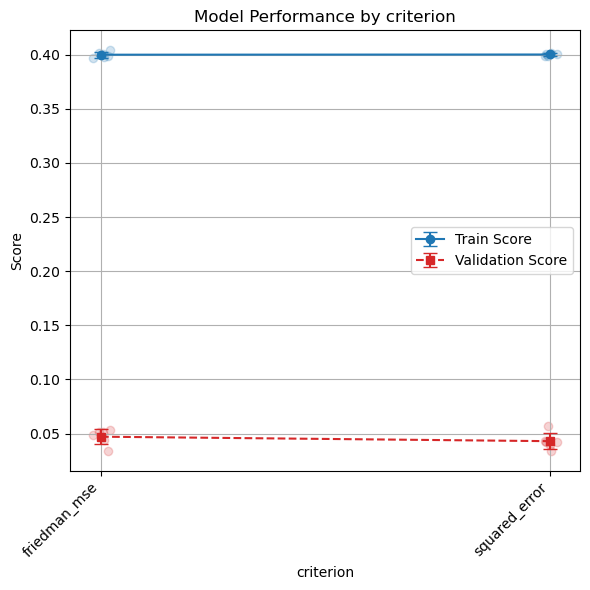

In [19]:
results_rf = results_rf.fillna("None")
mp.plot_model_performance(results_rf.copy(), param_grid_rf)

### XGBoost

In [59]:
params = {'eta': 0.14315876654070525, 'gamma': 0.15267525903299634, 'n_estimators': 259, 'subsample': 0.816012056487514, 'num_parallel_tree': 7, 'colsample_bytree': 0.7626462759013348, 'colsample_bylevel': 0.8006154025732285, 'colsample_bynode': 0.5140560102311738, 'max_depth': 9, 'min_child_weight': 6, 'lambda': 1.0107283039394311e-08, 'alpha': 0.2428371143422945, 'objective': 'reg:squarederror', 'max_leaves': 164}
model = xgb.XGBRegressor(n_jobs=-1, booster='gbtree', **params).fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
r_2_train = e.calculate_r2_oos(y_train, model.predict(X_train_scaled))
r_2_val = e.calculate_r2_oos(y_val, predictions)
print(f"r_2_train: {r_2_train}, r_2_val: {r_2_val}", )

r_2_train: 0.5482402311831475, r_2_val: 0.05931351233862736


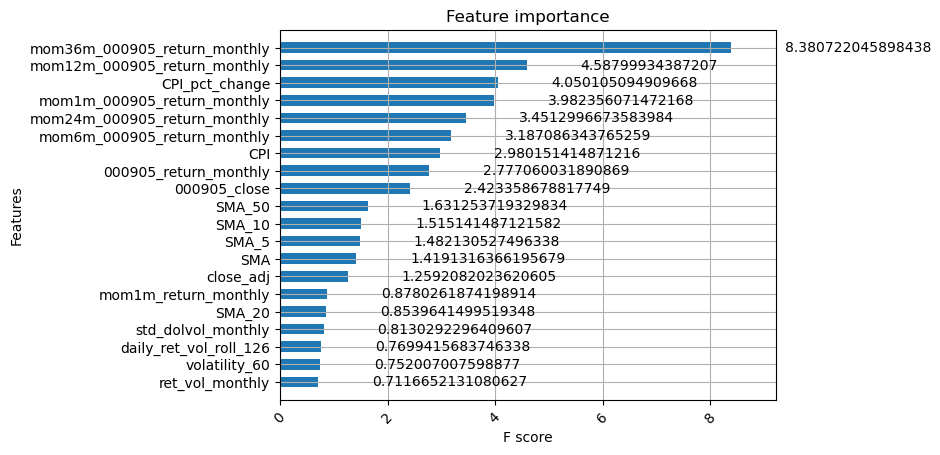

In [ ]:
xgb.plot_importance(model, max_num_features=20, height=0.6, importance_type='gain')
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.show()

In [52]:
param_grid_xgbt = {
    'eta': [0.0001, 0.001, 0.1],   #0 - 0.2
    'gamma': [1e-2,1e-1, 0.2],
    'n_estimators':[100, 200, 400],
    # 'num_parallel_tree': [1, 4, 8],
    'subsample': [0.75],
    'colsample_bytree': [0.75],
    'colsample_bylevel': [0.75],
    'colsample_bynode': [0.65],
    'alpha': [0.01, 0.1, 1],
    'lambda': [0.01, 0.1, 1],
    'max_leaves': [100, 200, 400],
    'objective': ['reg:squarederror', 'reg:pseudohubererror'],
    'n_jobs': [-1]
    }

results_xgbt = e.explore_parameter_grid(xgb.XGBRegressor, param_grid_xgbt, X_train_scaled, y_train, X_val_scaled, y_val, multiprocess=False)

  3%|▎         | 46/1458 [01:52<57:39,  2.45s/it]  


KeyboardInterrupt: 

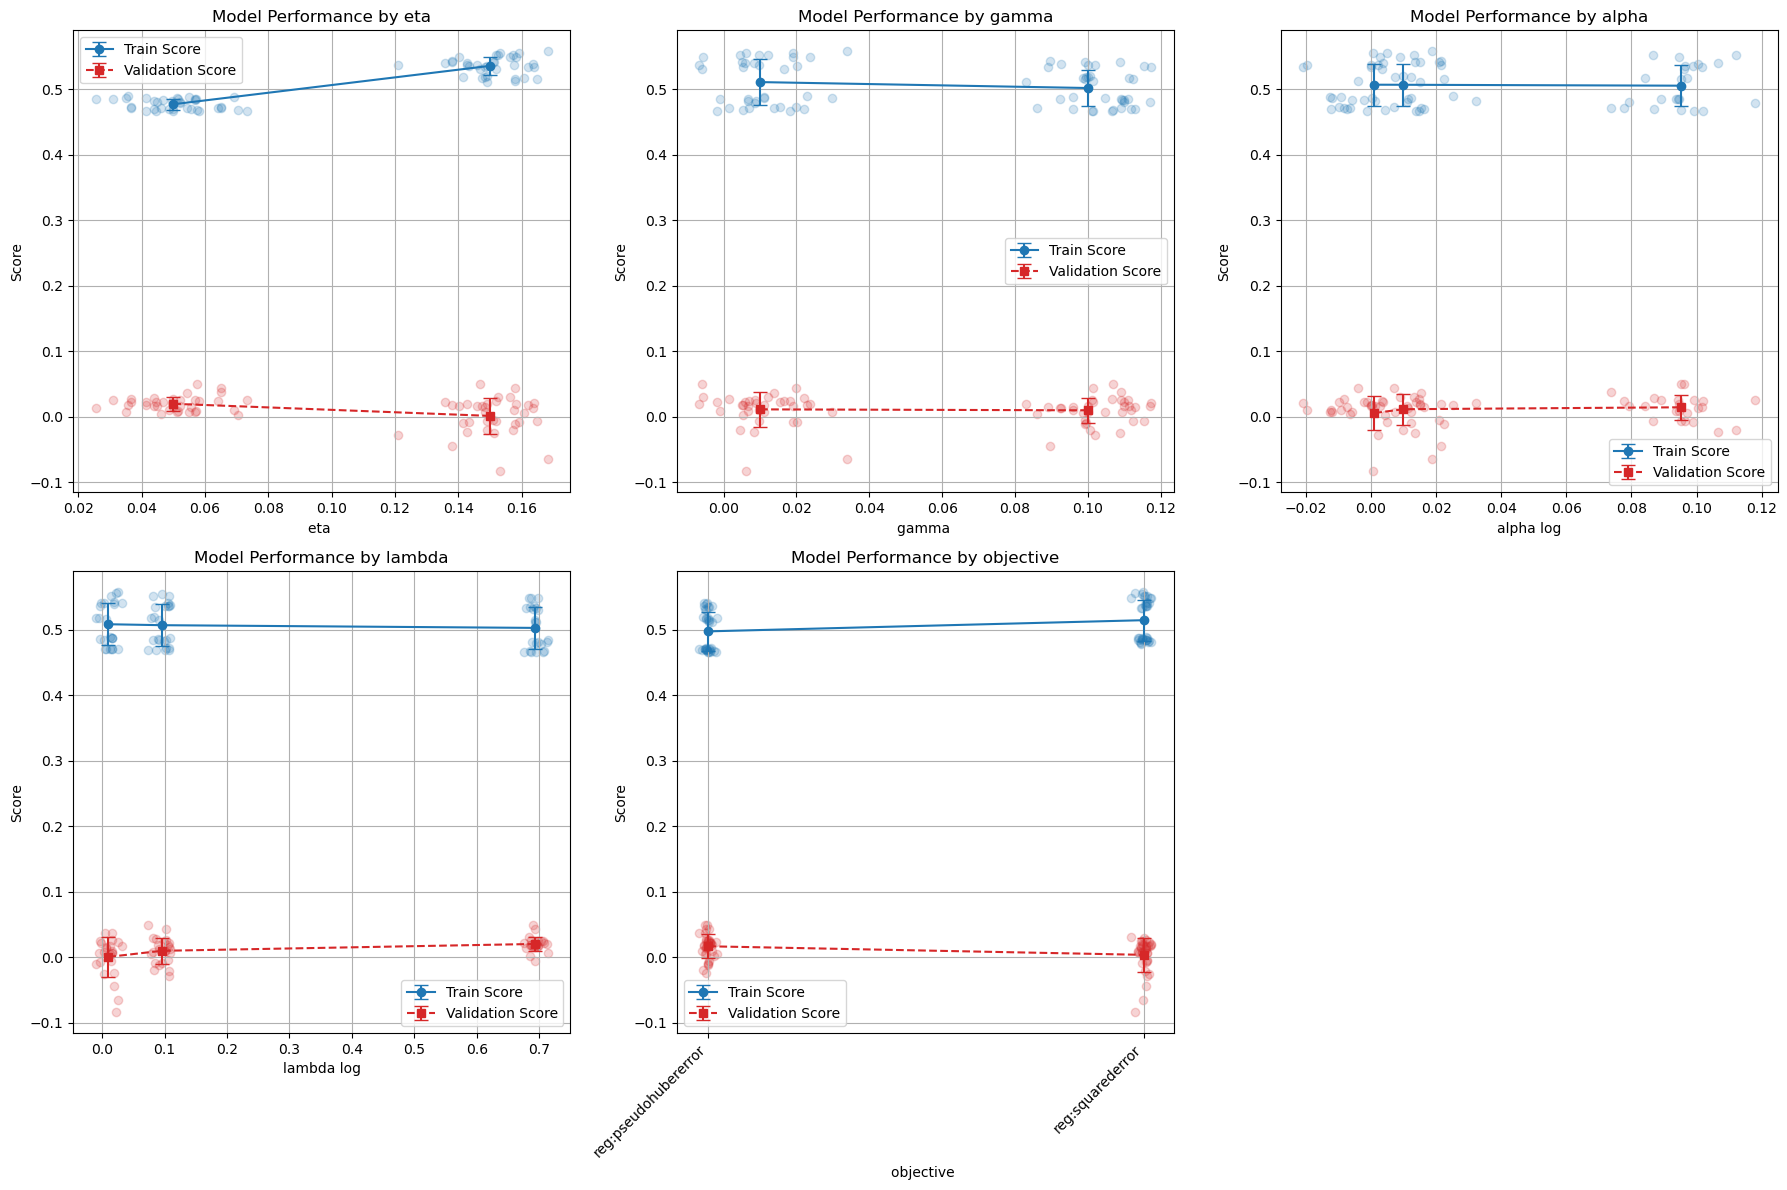

In [49]:
mp.plot_model_performance(results_xgbt.copy(), param_grid_xgbt)

### Nerual Networks

In [41]:
model = m.NNModel(input_dim=X_train.shape[1])
model.fit(X_train_scaled, y_train, X_val_scaled, y_val, num_epochs=100, patience=6)
model

Training:  18%|█▊        | 18/100 [00:41<03:11,  2.33s/it, Training loss=0.0217, Validation loss=0.0229]

Early stopping triggered at epoch 19


NNModel(
  (activation_function): ReLU()
  (model): Sequential(
    (0): Linear(in_features=49, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)

In [43]:
predictions = model.predict(X_val_scaled)
r_2_train = e.calculate_r2_oos(y_train, model.predict(X_train_scaled))
r_2_val = e.calculate_r2_oos(y_val, predictions)
print(f"r_2_train: {r_2_train}, r_2_val: {r_2_val}", )

r_2_train: 0.11233163781244992, r_2_val: -0.5261271447772995


In [82]:
param_grid_nn1 = {
    'num_layers': [3],
    'loss': ['huberloss'],
    'lambda': [10e-3, 0.1],
    'learning_rate': [0.0001, 0.001, 0.005, 0.01],
    'batch_size': [128, 10000],
    'activation': ['Relu', 'ELU', 'LeakyReLU'], # 'ELU'
    'batch_norm': [True, False], # , False
    'patience': [5],
    'output_dim': [1],
    }

results_nn1 = e.explore_parameter_grid(m.NNModel, param_grid_nn1, X_train_scaled, y_train, X_val_scaled, y_val, multiprocess=False)

  0%|          | 0/96 [00:00<?, ?it/s]

  1%|          | 1/96 [01:08<1:48:00, 68.22s/it]

Early stopping triggered at epoch 14


  2%|▏         | 2/96 [01:36<1:09:49, 44.56s/it]

Early stopping triggered at epoch 6


  3%|▎         | 3/96 [02:17<1:06:55, 43.18s/it]

Early stopping triggered at epoch 9


  4%|▍         | 4/96 [03:26<1:21:58, 53.46s/it]

Early stopping triggered at epoch 15


  5%|▌         | 5/96 [04:03<1:11:51, 47.38s/it]

Early stopping triggered at epoch 8


  6%|▋         | 6/96 [04:31<1:00:59, 40.66s/it]

Early stopping triggered at epoch 6


  7%|▋         | 7/96 [04:58<54:00, 36.40s/it]  

Early stopping triggered at epoch 6


  8%|▊         | 8/96 [05:35<53:32, 36.51s/it]

Early stopping triggered at epoch 8


  9%|▉         | 9/96 [05:49<42:29, 29.30s/it]

Early stopping triggered at epoch 6


 10%|█         | 10/96 [06:32<48:21, 33.74s/it]

Early stopping triggered at epoch 20


 11%|█▏        | 11/96 [07:07<48:04, 33.94s/it]

Early stopping triggered at epoch 16


 12%|█▎        | 12/96 [07:37<45:51, 32.75s/it]

Early stopping triggered at epoch 14


 15%|█▍        | 14/96 [12:01<1:44:26, 76.42s/it]

Early stopping triggered at epoch 20


 16%|█▌        | 15/96 [12:18<1:18:58, 58.50s/it]

Early stopping triggered at epoch 7


 17%|█▋        | 16/96 [12:36<1:01:37, 46.22s/it]

Early stopping triggered at epoch 7


 18%|█▊        | 17/96 [13:52<1:12:34, 55.13s/it]

Early stopping triggered at epoch 17


 19%|█▉        | 18/96 [14:22<1:01:57, 47.66s/it]

Early stopping triggered at epoch 6


 20%|█▉        | 19/96 [15:27<1:07:54, 52.92s/it]

Early stopping triggered at epoch 13


 21%|██        | 20/96 [16:35<1:12:43, 57.42s/it]

Early stopping triggered at epoch 14


 22%|██▏       | 21/96 [17:08<1:02:43, 50.19s/it]

Early stopping triggered at epoch 7


 23%|██▎       | 22/96 [18:01<1:02:51, 50.96s/it]

Early stopping triggered at epoch 11


 24%|██▍       | 23/96 [18:49<1:00:46, 49.95s/it]

Early stopping triggered at epoch 10


 25%|██▌       | 24/96 [19:28<55:53, 46.57s/it]  

Early stopping triggered at epoch 8


 26%|██▌       | 25/96 [20:17<56:03, 47.37s/it]

Early stopping triggered at epoch 19


 27%|██▋       | 26/96 [20:32<44:04, 37.78s/it]

Early stopping triggered at epoch 6


 28%|██▊       | 27/96 [20:47<35:38, 31.00s/it]

Early stopping triggered at epoch 6


 29%|██▉       | 28/96 [21:08<31:34, 27.86s/it]

Early stopping triggered at epoch 8


 31%|███▏      | 30/96 [27:24<1:53:25, 103.11s/it]

Early stopping triggered at epoch 44


 32%|███▏      | 31/96 [28:00<1:29:49, 82.92s/it] 

Early stopping triggered at epoch 14


 33%|███▎      | 32/96 [28:18<1:07:40, 63.45s/it]

Early stopping triggered at epoch 7


 34%|███▍      | 33/96 [29:43<1:13:15, 69.76s/it]

Early stopping triggered at epoch 16


 35%|███▌      | 34/96 [30:19<1:01:37, 59.64s/it]

Early stopping triggered at epoch 7


 36%|███▋      | 35/96 [31:38<1:06:37, 65.53s/it]

Early stopping triggered at epoch 15


 38%|███▊      | 36/96 [32:32<1:02:14, 62.25s/it]

Early stopping triggered at epoch 10


 39%|███▊      | 37/96 [33:16<55:46, 56.72s/it]  

Early stopping triggered at epoch 8


 40%|███▉      | 38/96 [34:22<57:32, 59.52s/it]

Early stopping triggered at epoch 12


 41%|████      | 39/96 [35:10<53:16, 56.07s/it]

Early stopping triggered at epoch 9


 42%|████▏     | 40/96 [36:04<51:37, 55.31s/it]

Early stopping triggered at epoch 10


 43%|████▎     | 41/96 [36:20<39:57, 43.60s/it]

Early stopping triggered at epoch 6


 44%|████▍     | 42/96 [36:50<35:30, 39.45s/it]

Early stopping triggered at epoch 11


 45%|████▍     | 43/96 [37:06<28:41, 32.49s/it]

Early stopping triggered at epoch 6


 46%|████▌     | 44/96 [37:22<23:51, 27.54s/it]

Early stopping triggered at epoch 6


 47%|████▋     | 45/96 [41:14<1:15:25, 88.73s/it]

Early stopping triggered at epoch 92


 48%|████▊     | 46/96 [42:06<1:04:44, 77.69s/it]

Early stopping triggered at epoch 22


 49%|████▉     | 47/96 [42:19<47:44, 58.46s/it]  

Early stopping triggered at epoch 6


 50%|█████     | 48/96 [42:35<36:33, 45.70s/it]

Early stopping triggered at epoch 7


 51%|█████     | 49/96 [43:57<44:14, 56.48s/it]

Early stopping triggered at epoch 19


 52%|█████▏    | 50/96 [44:37<39:29, 51.52s/it]

Early stopping triggered at epoch 10


 53%|█████▎    | 51/96 [45:09<34:24, 45.87s/it]

Early stopping triggered at epoch 8


 54%|█████▍    | 52/96 [45:42<30:45, 41.94s/it]

Early stopping triggered at epoch 8


 55%|█████▌    | 53/96 [46:46<34:39, 48.36s/it]

Early stopping triggered at epoch 15


 56%|█████▋    | 54/96 [47:10<28:54, 41.31s/it]

Early stopping triggered at epoch 6


 57%|█████▋    | 55/96 [47:42<26:14, 38.41s/it]

Early stopping triggered at epoch 8


 58%|█████▊    | 56/96 [48:19<25:20, 38.02s/it]

Early stopping triggered at epoch 9


 59%|█████▉    | 57/96 [50:46<46:01, 70.81s/it]

Early stopping triggered at epoch 67


 60%|██████    | 58/96 [51:12<36:13, 57.20s/it]

Early stopping triggered at epoch 9


 61%|██████▏   | 59/96 [51:32<28:20, 45.96s/it]

Early stopping triggered at epoch 6


 62%|██████▎   | 60/96 [51:48<22:11, 36.99s/it]

Early stopping triggered at epoch 6


 65%|██████▍   | 62/96 [58:58<1:09:18, 122.31s/it]

Early stopping triggered at epoch 56


 66%|██████▌   | 63/96 [59:32<52:35, 95.62s/it]   

Early stopping triggered at epoch 12


 67%|██████▋   | 64/96 [59:48<38:19, 71.86s/it]

Early stopping triggered at epoch 6


 68%|██████▊   | 65/96 [1:00:57<36:38, 70.93s/it]

Early stopping triggered at epoch 13


 69%|██████▉   | 66/96 [1:02:23<37:48, 75.60s/it]

Early stopping triggered at epoch 15


 70%|██████▉   | 67/96 [1:04:20<42:26, 87.81s/it]

Early stopping triggered at epoch 21


 71%|███████   | 68/96 [1:05:09<35:32, 76.17s/it]

Early stopping triggered at epoch 9


 72%|███████▏  | 69/96 [1:05:54<30:05, 66.86s/it]

Early stopping triggered at epoch 8


 73%|███████▎  | 70/96 [1:07:00<28:51, 66.60s/it]

Early stopping triggered at epoch 12


 74%|███████▍  | 71/96 [1:08:21<29:32, 70.91s/it]

Early stopping triggered at epoch 15


 75%|███████▌  | 72/96 [1:09:13<26:05, 65.25s/it]

Early stopping triggered at epoch 11


 76%|███████▌  | 73/96 [1:10:51<28:46, 75.07s/it]

Early stopping triggered at epoch 43


 77%|███████▋  | 74/96 [1:11:13<21:43, 59.26s/it]

Early stopping triggered at epoch 10


 78%|███████▊  | 75/96 [1:11:55<18:56, 54.10s/it]

Early stopping triggered at epoch 17


 79%|███████▉  | 76/96 [1:12:13<14:26, 43.32s/it]

Early stopping triggered at epoch 7


 80%|████████  | 77/96 [1:14:42<23:45, 75.02s/it]

Early stopping triggered at epoch 61


 81%|████████▏ | 78/96 [1:15:22<19:17, 64.29s/it]

Early stopping triggered at epoch 16


 82%|████████▏ | 79/96 [1:15:54<15:29, 54.69s/it]

Early stopping triggered at epoch 13


 83%|████████▎ | 80/96 [1:16:14<11:47, 44.21s/it]

Early stopping triggered at epoch 8


 84%|████████▍ | 81/96 [1:17:17<12:28, 49.89s/it]

Early stopping triggered at epoch 14


 85%|████████▌ | 82/96 [1:17:49<10:25, 44.68s/it]

Early stopping triggered at epoch 7


 86%|████████▋ | 83/96 [1:18:29<09:22, 43.25s/it]

Early stopping triggered at epoch 9


 88%|████████▊ | 84/96 [1:19:32<09:48, 49.04s/it]

Early stopping triggered at epoch 14


 89%|████████▊ | 85/96 [1:20:12<08:29, 46.29s/it]

Early stopping triggered at epoch 9


 90%|████████▉ | 86/96 [1:21:06<08:06, 48.69s/it]

Early stopping triggered at epoch 12


 91%|█████████ | 87/96 [1:21:37<06:31, 43.49s/it]

Early stopping triggered at epoch 7


 92%|█████████▏| 88/96 [1:22:27<06:03, 45.44s/it]

Early stopping triggered at epoch 11


 93%|█████████▎| 89/96 [1:23:52<06:41, 57.30s/it]

Early stopping triggered at epoch 35


 94%|█████████▍| 90/96 [1:24:15<04:41, 46.89s/it]

Early stopping triggered at epoch 9


 95%|█████████▍| 91/96 [1:24:32<03:09, 37.96s/it]

Early stopping triggered at epoch 7


 96%|█████████▌| 92/96 [1:24:54<02:13, 33.27s/it]

Early stopping triggered at epoch 9


 98%|█████████▊| 94/96 [1:29:21<02:28, 74.04s/it]

Early stopping triggered at epoch 8


 99%|█████████▉| 95/96 [1:29:53<01:01, 61.35s/it]

Early stopping triggered at epoch 13


100%|██████████| 96/96 [1:30:12<00:00, 56.38s/it]

Early stopping triggered at epoch 8


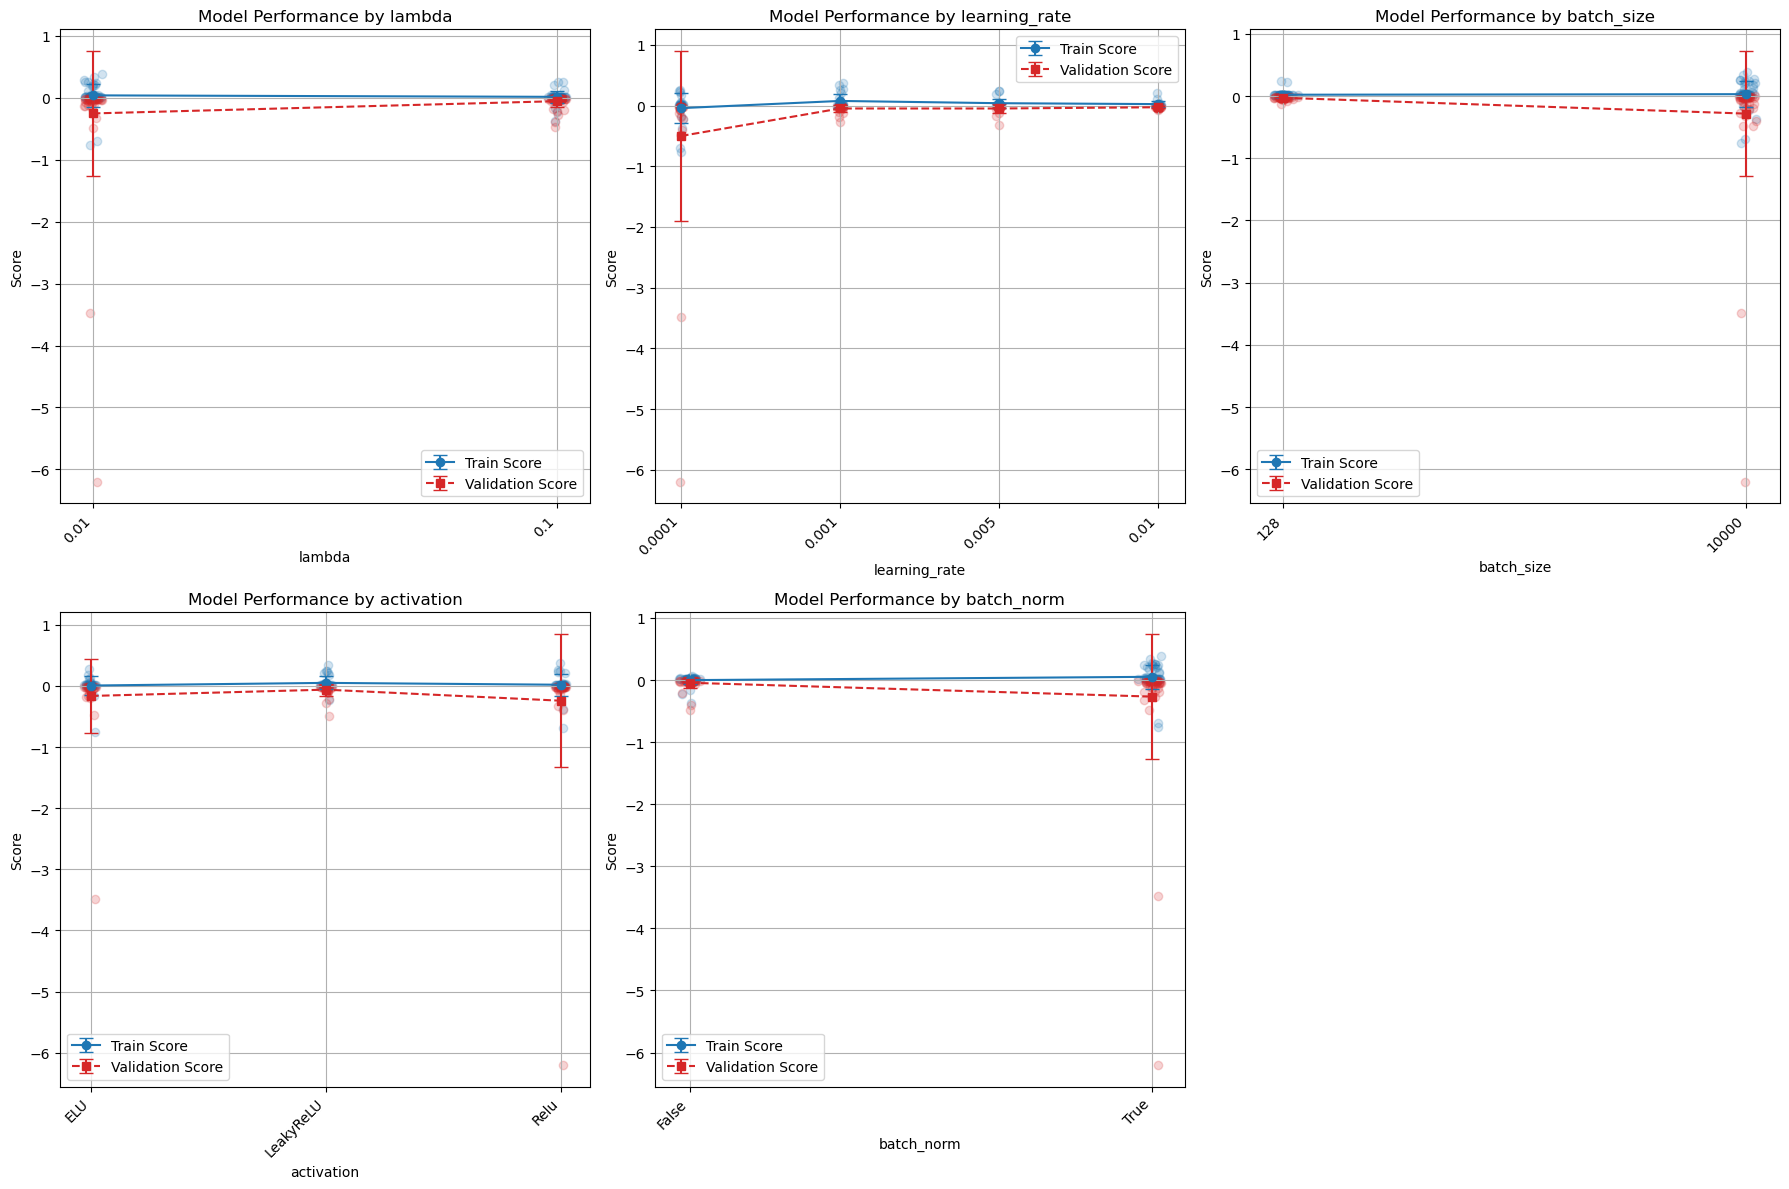

In [83]:
mp.plot_model_performance(results_nn1.copy(), param_grid_nn1)

## Hyperparameter tuning

In [66]:
models_to_tune = [
    # m.OLSModel,
    # m.OLS3Model,
    # m.PLSModel,
    # m.LASSOModel,
    # m.ElasticNetModel,
    # m.GBRTModel,
    # m.RFModel,
    m.XGBoostModel
]
best_trials, studies = e.hyperparameter_tuning(X_train_scaled, y_train, X_val_scaled, y_val, models_to_tune, n_trials=1500)

Tuning Models:   0%|          | 0/1 [00:00<?, ?it/s][I 2024-04-03 01:57:02,104] A new study created in memory with name: no-name-07f797f3-bcdc-4a9a-9140-26f9b2c7ebab


Tunning XGBoostModel


[I 2024-04-03 01:57:39,281] Trial 0 finished with value: 0.000534733189369252 and parameters: {'eta': 0.003333944574335982, 'gamma': 0.0008461375055517789, 'n_estimators': 495, 'subsample': 0.9217056375234881, 'num_parallel_tree': 7, 'colsample_bytree': 0.8773372724214719, 'colsample_bylevel': 0.8693578336554432, 'colsample_bynode': 0.4470657614750837, 'max_depth': 29, 'min_child_weight': 122, 'lambda': 0.0006336270691998289, 'alpha': 5.89885539117386, 'objective': 'reg:pseudohubererror', 'grow_policy': 'depthwise', 'max_leaves': 14}. Best is trial 0 with value: 0.000534733189369252.
[W 2024-04-03 01:58:40,166] Trial 1 failed with parameters: {'eta': 0.0002458322438927926, 'gamma': 0.0010666803702967986, 'n_estimators': 815, 'subsample': 0.8545034044215354, 'num_parallel_tree': 5, 'colsample_bytree': 0.9864383719599373, 'colsample_bylevel': 0.9855682970332273, 'colsample_bynode': 0.35265149140944324, 'max_depth': 10, 'min_child_weight': 22, 'lambda': 0.0015572913875349479, 'alpha': 0.8

KeyboardInterrupt: 

In [54]:

fig = optuna.visualization.plot_param_importances(studies['XGBoostModel'])
fig.show()

In [55]:
fig = optuna.visualization.plot_optimization_history(studies['XGBoostModel'])
fig.show()

In [56]:
optuna.visualization.plot_slice(studies['XGBoostModel'])

### NN

In [8]:
best_trials, studies = e.nn_tunning(range(1, 1+1), X_train_scaled, y_train, X_val_scaled, y_val, n_trials=2)

Tuning Models:   0%|          | 0/1 [00:00<?, ?it/s][I 2024-04-03 02:13:12,898] A new study created in memory with name: no-name-b68a4ca9-234a-4e83-9598-20b71360f733


Tunning 1













Training:   5%|▌         | 5/100 [00:45<14:32,  9.18s/it, Training loss=0.00818, Validation loss=0.00874]
[I 2024-04-03 02:13:58,904] Trial 0 finished with value: -0.13235818320808135 and parameters: {'objective': 'huberloss', 'lambda_value': 0.00020473820140404217, 'learning_rate': 0.003557436633061197, 'batch_size': 2048}. Best is trial 0 with value: -0.13235818320808135.


Early stopping triggered at epoch 6


Training:   5%|▌         | 5/100 [00:49<15:32,  9.82s/it, Training loss=0.0159, Validation loss=0.0259]
[I 2024-04-03 02:14:02,076] Trial 1 finished with value: -0.5924707235226843 and parameters: {'objective': 'mse', 'lambda_value': 6.886562650048688e-05, 'learning_rate': 0.00015932932167526473, 'batch_size': 512}. Best is trial 0 with value: -0.13235818320808135.
Tuning Models: 100%|██████████| 1/1 [00:49<00:00, 49.18s/it]

Early stopping triggered at epoch 6


In [13]:
fig = optuna.visualization.plot_param_importances(studies['NNModel_nn1'])
fig.show()

In [14]:
fig = optuna.visualization.plot_optimization_history(studies['NNModel_nn1'])
fig.show()

In [15]:
optuna.visualization.plot_slice(studies['NNModel_nn1'])

### Testing

In [6]:
model_classes = [
    m.OLSModel(),
    # m.OLS3Model(),
    # m.PLSModel(),
    m.LASSOModel(),
    m.ElasticNetModel(),
    # m.GBRTModel(), #extremely slow 
    # m.RFModel(), 
    m.XGBoostModel()
]
num_layers_range = range(1, 5+1)
# for num_layers in num_layers_range:
#     model_classes.append(m.NNModel(input_dim=input_dim, num_layers=num_layers))
models_fitted, model_res, model_r_2 = m.fit_model(X_train, X_test,  X_val, y_val, y_train, y_test, model_classes)

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

OLSModel


Testing:  20%|██        | 1/5 [00:33<02:12, 33.01s/it, Model Name=OLSModel, R_2=-1.36]


OLS3Model


KeyError: "['mom1m'] not in index"

### Feature Importance

In [34]:
model_classes = [
    # m.OLSModel(),
    # m.OLS3Model(),
    # m.PLSModel(),
    # m.LASSOModel(),
    # m.ElasticNetModel(),
    # m.GBRTModel(), #extremely slow 
    # m.RFModel(), 
    m.XGBoostModel()
]
# num_layers_range = range(1, 1+1)
# for num_layers in num_layers_range:
#     model_classes.append(m.NNModel(input_dim=input_dim, num_layers=num_layers))

importance_df_current = e.calculate_feature_importance(model_classes, X_train, y_train, X_val, y_val, features=X_train.columns, permutation_importance=True)

Calculating Feature Importance: 100%|██████████| 1/1 [00:31<00:00, 31.09s/it, Model Name=XGBoostModel, Variable=excess_return, n=49/49]       


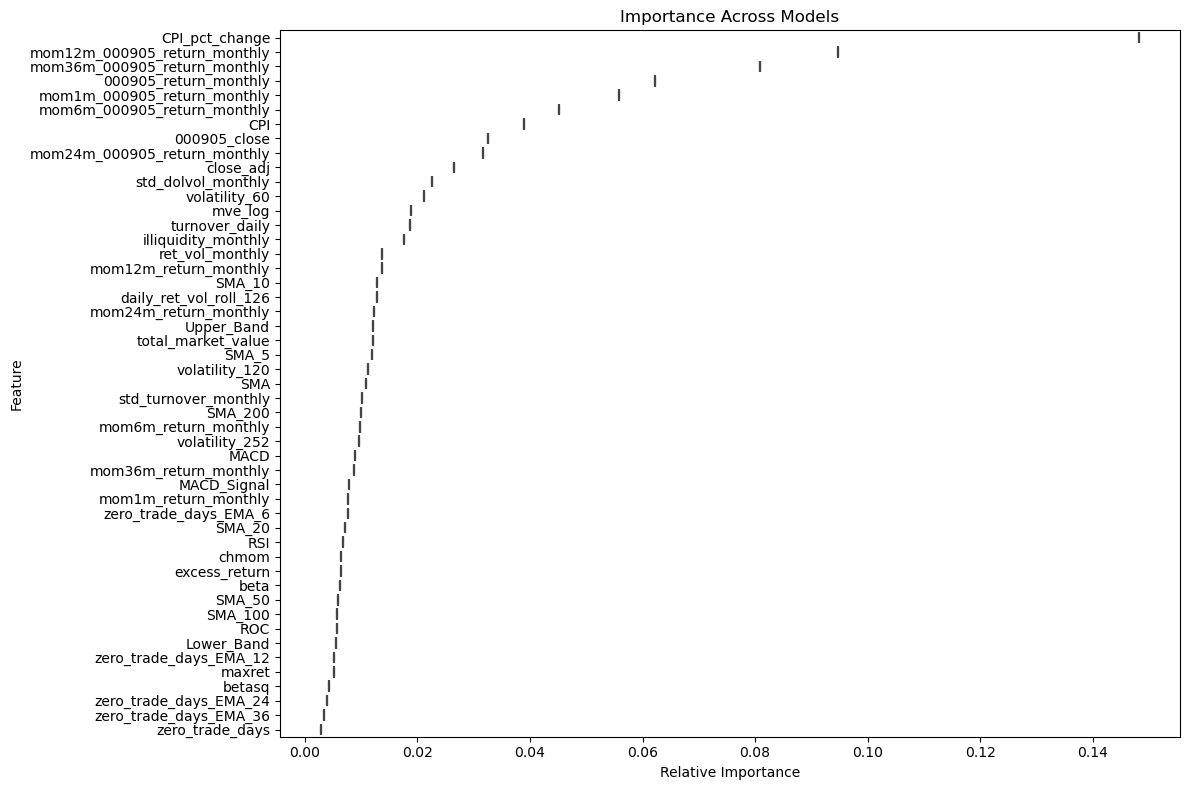

In [35]:
mp.feature_importance_boxplot(importance_df_current)


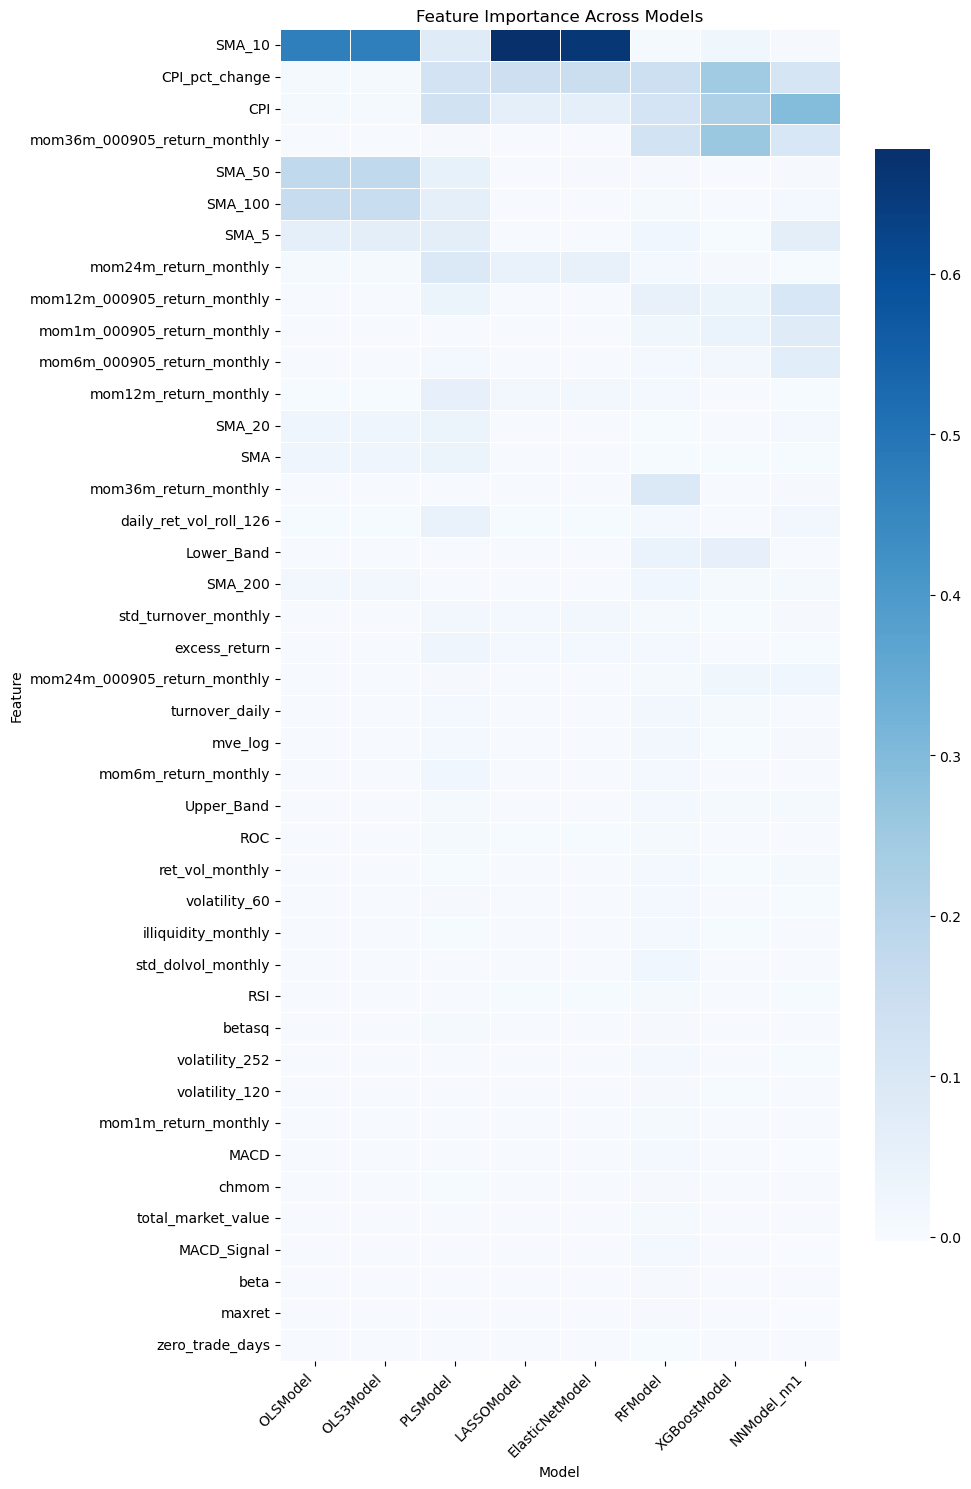

In [46]:
sorted_df = mp.characteristic_feature_importance(importance_df_current)

## Portfolio analysis